In [7]:
%matplotlib inline
from __future__ import division

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Normal

plt.style.use('ggplot')

$\large{\textbf{Appetizer Example}}$

Fitting  $$f: x \mapsto cos(x)$$

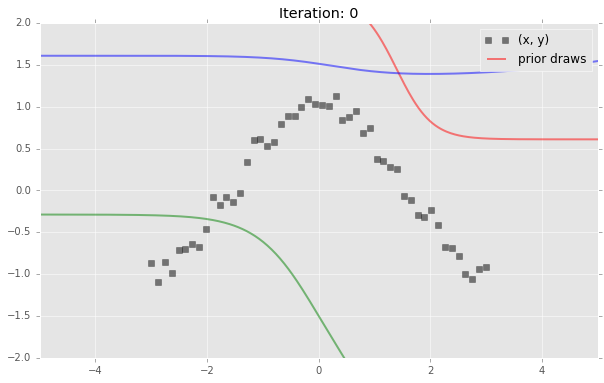

In [47]:
# Set up comp-graph and visualize initialized params (or priors)

def build_toy_dataset(N=50, noise_std=0.1):
    '''
    Create a random data set with f: x -> cos(x).
    N: data size.
    noise_std: for random jittering.
    '''
    x = np.linspace(-3, 3, num=N) # array going from -3 to 3 in N steps.
    y = np.cos(x) + np.random.normal(0, noise_std, size=N) # cos func + rand-purturbation.
    x = x.astype(np.float32).reshape((N,1))
    y = y.astype(np.float32)
    return x, y

def neural_network(x, W_0, W_1, b_0, b_1):
    h = tf.tanh(tf.matmul(x, W_0) + b_0)
    h = tf.matmul(h, W_1) + b_1
    return tf.reshape(h, [-1])

N = 50 # data size
D = 1  # number of features (i.e. x)

x_train, y_train = build_toy_dataset(N)

# Build neural net 
#   dimensions:
#     h = x*W_0 + b_0: 1 * (1x2) + 2 = 2
#     h = h*W_1 + b_1: 2 * (2x1) + 1 = 1 (to dim.y now)
W_0 = Normal(loc=tf.zeros([D, 2]), scale=tf.ones([D, 2]))
W_1 = Normal(loc=tf.zeros([2, 1]), scale=tf.ones([2, 1]))
b_0 = Normal(loc=tf.zeros(2), scale=tf.ones(2))
b_1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

x = x_train
y = Normal(loc=neural_network(x, W_0, W_1, b_0, b_1),
           scale=0.1 * tf.ones(N))

# Set up variational dist'n
#   the objective is to use variational dist'n
#   to approximate the real dist'n of the weights and biases.
#   dimensions: the same as the dist'n to be approximated.
qW_0 = Normal(loc=tf.Variable(tf.random_normal([D, 2])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, 2]))))
qW_1 = Normal(loc=tf.Variable(tf.random_normal([2, 1])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([2, 1]))))
qb_0 = Normal(loc=tf.Variable(tf.random_normal([2])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([2]))))
qb_1 = Normal(loc=tf.Variable(tf.random_normal([1])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

# Visualizing the priors
rs = np.random.RandomState(0) # Mersenne Twister pseudo-random number generator
inputs = np.linspace(-5, 5, num=400, dtype=np.float32)
x = tf.expand_dims(inputs, 1) # (400,) -> (400,1)
mus = tf.stack([neural_network(x, qW_0.sample(), qW_1.sample(),
                                  qb_0.sample(), qb_1.sample())
                for _ in range(10)]) # generate 10 samples of params (10,400)
sess = ed.get_session()
tf.global_variables_initializer().run()
outputs = mus.eval()
# visualize the first three samples 
#   true: block dots
#   approx: (red, blue, green)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 0")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)') # alpha: opaque scale.
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='prior draws')
ax.plot(inputs, outputs[1].T, 'b', lw=2, alpha=0.5)
ax.plot(inputs, outputs[2].T, 'g', lw=2, alpha=0.5)
# ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5) # this prints all samples.
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.show()

1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Loss: -4.141


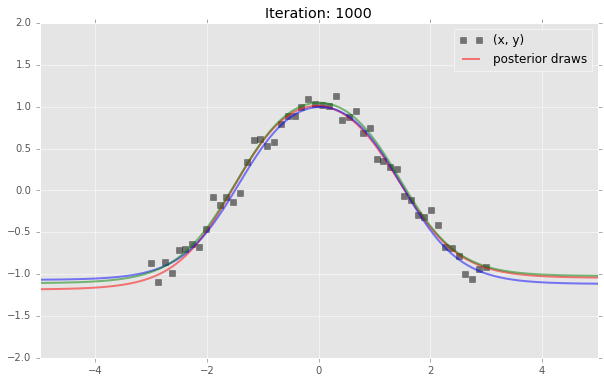

In [48]:
# Inference

# Inference using blackbox VI
#   KLqp({p:q, ...}, data={...})
#   where p is the true, q is the varaiational approximator.
inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1}, data={y: y_train})
inference.run(n_iter=1000, n_samples=5)

# Visualize the results of fit
outputs = mus.eval() # this is after fitting.

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 1000")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='posterior draws')
ax.plot(inputs, outputs[1].T, 'b', lw=2, alpha=0.5)
ax.plot(inputs, outputs[2].T, 'g', lw=2, alpha=0.5)
# ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.show()

$\large{\textbf{Mixture Model}}$

Generative Story

$$\begin{align*} p(\pi) &\sim \text{Dir}(\pi|\textbf{$\alpha$}) \\
p(\mu_k) &\sim \mathcal{N}(\mu_k|\mathbf{0,I}) \\
p(\sigma_k^2) &\sim \text{Inv-Gamma}(\sigma_k^2|a,b)  \end{align*}$$

NB: (i) $\textbf{$\alpha$}$ is a $K$-dimensional vector, each corresponds to a cluster; (ii) Each cluster $k$ gets a pair of Gaussian params $(\mu_k,\sigma_k^2)$, where $\mu_k$ is distributed by a standard normal, and $\sigma_k^2$ follows an inverse Gamma, parameterized by any chosen constants $(a,b)$.

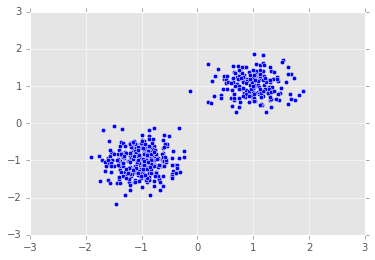

In [2]:
# Build and visualize data

def build_toy_dataset(N):
    '''
    Create random data with a generative story.
    pi: Dirichlet probabilities (with params .4-.6 in 2D).
    mus, stds: Params of 2D Gaussians (1 pair per cluster).
    '''
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = [[0.1, 0.1], [0.1, 0.1]]
    x = np.zeros((N, 2), dtype=np.float32)
    # generative story
    for n in range(N): # for the require #entries
        # pick the best cluster (from sample)
        k = np.argmax(np.random.multinomial(1, pi)) 
        # sample a data point from 2D normal parameterized by the (mu,std)
        # of the chosen cluster in the previous step.
        x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k])) 
    return x

N = 500  # number of data points
D = 2  # dimensionality of data

x_train = build_toy_dataset(N)

# Visualize
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.axis([-3, 3, -3, 3])
plt.show()

### Gibbs

In [123]:
# Build model

from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag
from edward.models import Normal, Empirical, ParamMixture
# ParamMixture
#   Def: A mixture distribution where all components are of the same family.
#   E.g: 5D cluster vector where each is a Normal.
#     probs = tf.ones(5) / 5.0
#     params = {'mu': tf.zeros(5), 'sigma': tf.ones(5)}
#     x = ParamMixture(probs, params, Normal)

K = 2  # number of components (cuz we generated by 2 clusters earlier)

# Method 1: explicit latent variable assignments (z)
pi = Dirichlet(tf.ones(K)) # cluster ~ dirichlet
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K) # mean ~ standard normals 
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K) # variance ~ inv-gamma
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 MultivariateNormalDiag,
                 sample_shape=N) # mixture random variable wrapper
z = x.cat # latent var ~ Cat(pi)

T = 500 # number of MCMC samples
# dimensions:
#   T: #samples; K: #clusters; D: data dimensionality (2D)
qpi = Empirical(tf.Variable(tf.ones([T, K]) / K)) # divide by K to normalize
qmu = Empirical(tf.Variable(tf.zeros([T, K, D]))) # mean = 0
qsigmasq = Empirical(tf.Variable(tf.ones([T, K, D]))) # variance = 1
qz = Empirical(tf.Variable(tf.zeros([T, N], dtype=tf.int32)))

100/500 [ 20%] ██████                         ETA: 23s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.84360284 -0.84626359]
 [ 0.84062099  0.83244473]]

Inferred cluster variances:
[[ 0.28313658  0.26296008]
 [ 0.18670844  0.33406186]]
200/500 [ 40%] ████████████                   ETA: 10s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.91034132 -0.91613096]
 [ 0.91211641  0.91791183]]

Inferred cluster variances:
[[ 0.20020132  0.17646614]
 [ 0.14548935  0.22324143]]
300/500 [ 60%] ██████████████████             ETA: 5s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.93233621 -0.93970311]
 [ 0.93565601  0.94590282]]

Inferred cluster variances:
[[ 0.17350857  0.14779793]
 [ 0.13171417  0.1867321 ]]
400/500 [ 80%] ████████████████████████       ETA: 2s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.94236469 -0.95067579]
 [ 0.94784391  0.95992088]]

Inferred cluster variances:
[[ 0.15999831  0.13339762]
 [ 0.12483319  0.16816975]]
500/500 [100%] ███████████████

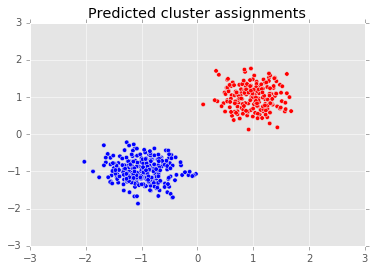

In [124]:
# Inference with Gibbs

import time

start = time.time()

inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz},
                     data={x: x_train})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
# running mean value from 0 to t_ph, t_ph = so far.
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)
running_cluster_vars = tf.reduce_mean(qsigmasq.params[:t_ph], 0)

for _ in range(inference.n_iter):
    info_dict = inference.update() # Run one iteration of sampling.
    inference.print_progress(info_dict)
    t = info_dict['t']
    # if t % inference.n_print == 0: # default = 5
    if t % 100 == 0:
        print("\nInferred cluster means:")
        print(sess.run(running_cluster_means, {t_ph: t - 1}))
        print("\nInferred cluster variances:")
        print(sess.run(running_cluster_vars, {t_ph: t - 1}))
        print
        
print
print 'Time taken = ' + repr(time.time()-start)
print
        
# Inference by taking 100 samples and average
mu_sample = qmu.sample(100) # get (100,2,2) samples, K=2, D=2
sigmasq_sample = qsigmasq.sample(100) # same as mu
# dimensions:
#    [N,1,1,1] = [N,T,K,D]
#    N: #entries.
#    T: #samples; K: #clusters; D: data dimensionality (2D)
# x_post shape: (N=500,T=100,K=2,D=2)
x_post = Normal(loc=tf.ones([N, 1, 1, 1]) * mu_sample,
                scale=tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample))
# Tiling the input
# a = tf.placeholder(tf.float32, [2,3])
# # create 1 copy along dim1, 2 copies along dim2
# #   result:
# #   [[ 1.  2.  3.]    <= in
# #    [ 4.  5.  6.]]
# #   [[ 1.  2.  3.  1.  2.  3.]    <= out
# #    [ 4.  5.  6.  4.  5.  6.]]
# ta = tf.tile(a, [1,2]) 
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     print sess.run(a, feed_dict={a:np.array([[1,2,3],
#                                              [4,5,6]],dtype=np.float32)})
#     print sess.run(ta, feed_dict={a:np.array([[1,2,3],
#                                               [4,5,6]],dtype=np.float32)})
# x_broadcasted shape: (N=500,T=100,K=2,D=2)
#   why do this? to compute the loglikelihood of the input data,
#   we are making 100 samples for each data point.
#   and then take the average over the 100 samples.
x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, 100, K, 1])

# Sum over latent dimension (D=2), then average over posterior samples (T=100).
# ``log_liks`` ends up with shape (N, K).
# log p(cluster|data point)
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)

# Cluster assignment
clusters = tf.argmax(log_liks, 1).eval()

# Visualize
import matplotlib.cm as cm
plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
plt.show()

### Variational Inference

    1/20000 [  0%]                                ETA: 70855s | Loss: 9598.648
Inferred cluster means:
[[ 0.18193516 -0.51159358]
 [-0.24076262 -1.37829065]]
 2000/20000 [ 10%] ███                            ETA: 49s | Loss: 2147.629
Inferred cluster means:
[[ 1.02912533  0.64909154]
 [-0.70996034  1.93353617]]
 4000/20000 [ 20%] ██████                         ETA: 29s | Loss: 2045.699
Inferred cluster means:
[[ 1.03700686  0.90500098]
 [-0.53454685  1.84003353]]
 6000/20000 [ 30%] █████████                      ETA: 21s | Loss: 1765.010
Inferred cluster means:
[[ 1.04349875  0.95826304]
 [-0.5155161   1.90132105]]
 8000/20000 [ 40%] ████████████                   ETA: 16s | Loss: 4057.601
Inferred cluster means:
[[ 1.04442418  0.95230782]
 [-0.52497411  1.90327001]]
10000/20000 [ 50%] ███████████████                ETA: 13s | Loss: 4691.232
Inferred cluster means:
[[ 1.04435241  0.95236379]
 [-0.52550334  1.90358019]]
12000/20000 [ 60%] ██████████████████             ETA: 10s | Loss: 

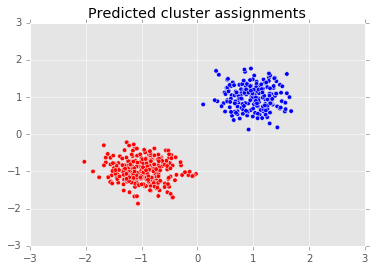

In [193]:
# Build Mmodel

from edward.models import Categorical, Dirichlet, InverseGamma, Normal

K = 2

pi = Dirichlet(tf.ones(K))
mu = Normal(loc=tf.zeros([K, D]), scale=tf.ones([K, D]))
sigma = InverseGamma(concentration=tf.ones([K, D]), rate=tf.ones([K, D]))
cat = Categorical(probs=pi, sample_shape=N)
components = [
    MultivariateNormalDiag(mu[k], sigma[k], sample_shape=N)
    for k in range(K)
]
x = Mixture(cat=cat, components=components, sample_shape=N)

qpi = Dirichlet(
    concentration=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))
qmu = Normal(loc=tf.Variable(tf.random_normal([K, D])),
             scale=tf.nn.softplus(tf.Variable(tf.random_normal([K, D]))))
qsigma = InverseGamma(
    concentration=tf.nn.softplus(tf.Variable(tf.random_normal([K, D]))),
    rate=tf.nn.softplus(tf.Variable(tf.random_normal([K, D]))))

inference = ed.KLqp(
    latent_vars={pi: qpi, mu: qmu, sigma: qsigma},
    data={x: x_train})

inference.initialize(n_iter=20000, n_print=2000)

sess = ed.get_session()
tf.global_variables_initializer().run()

for _ in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    t = info_dict['t']
    if t == 1 or t % inference.n_print == 0:
        qpi_mean, qmu_mean, qsigma_mean = \
            sess.run([qpi.mean(), qmu.mean(), qsigma.mean()])
        print '\nInferred cluster means:'
        print qmu_mean # print only mean now.

# Inference by taking 200 samples and average
mu_sample = qmu.sample(200) # get (100,2,2) samples, K=2, D=2
sigma_sample = qsigma.sample(200) # same as mu
# dimensions:
#    [N,1,1,1] = [N,T,K,D]
#    N: #entries.
#    T: #samples; K: #clusters; D: data dimensionality (2D)
# x_post shape: (N=500,T=100,K=2,D=2)
x_post = Normal(loc=tf.ones([N, 1, 1, 1]) * mu_sample,
                scale=tf.ones([N, 1, 1, 1]) * tf.sqrt(sigma_sample))
x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, 200, K, 1])

log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)

# Cluster assignment
clusters = tf.argmax(log_liks, 1).eval()

# Visualize
import matplotlib.cm as cm
plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
plt.show()